   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
  Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl.metadata (1.2 kB)
Using cached catboost-1.2.8-cp312-cp312-manylinux2014_x86_64.whl (99.2 MB)
Training and evaluating models...


MODEL PERFORMANCE SUMMARY (sorted by R² Score)

ExtraTrees          
  R² Score:       0.9949
  RMSE:           0.3643
  MAE:            0.2020
  CV R² (5-fold): 0.9966 ± 0.0014
------------------------------------------------------------
LinearRegression    
  R² Score:       0.9937
  RMSE:           0.4040
  MAE:            0.3420
  CV R² (5-fold): 0.9964 ± 0.0018
------------------------------------------------------------
Ridge               
  R² Score:       0.9937
  RMSE:           0.4043
  MAE:            0.3418
  CV R² (5-fold): 0.9964 ± 0.0018
------------------------

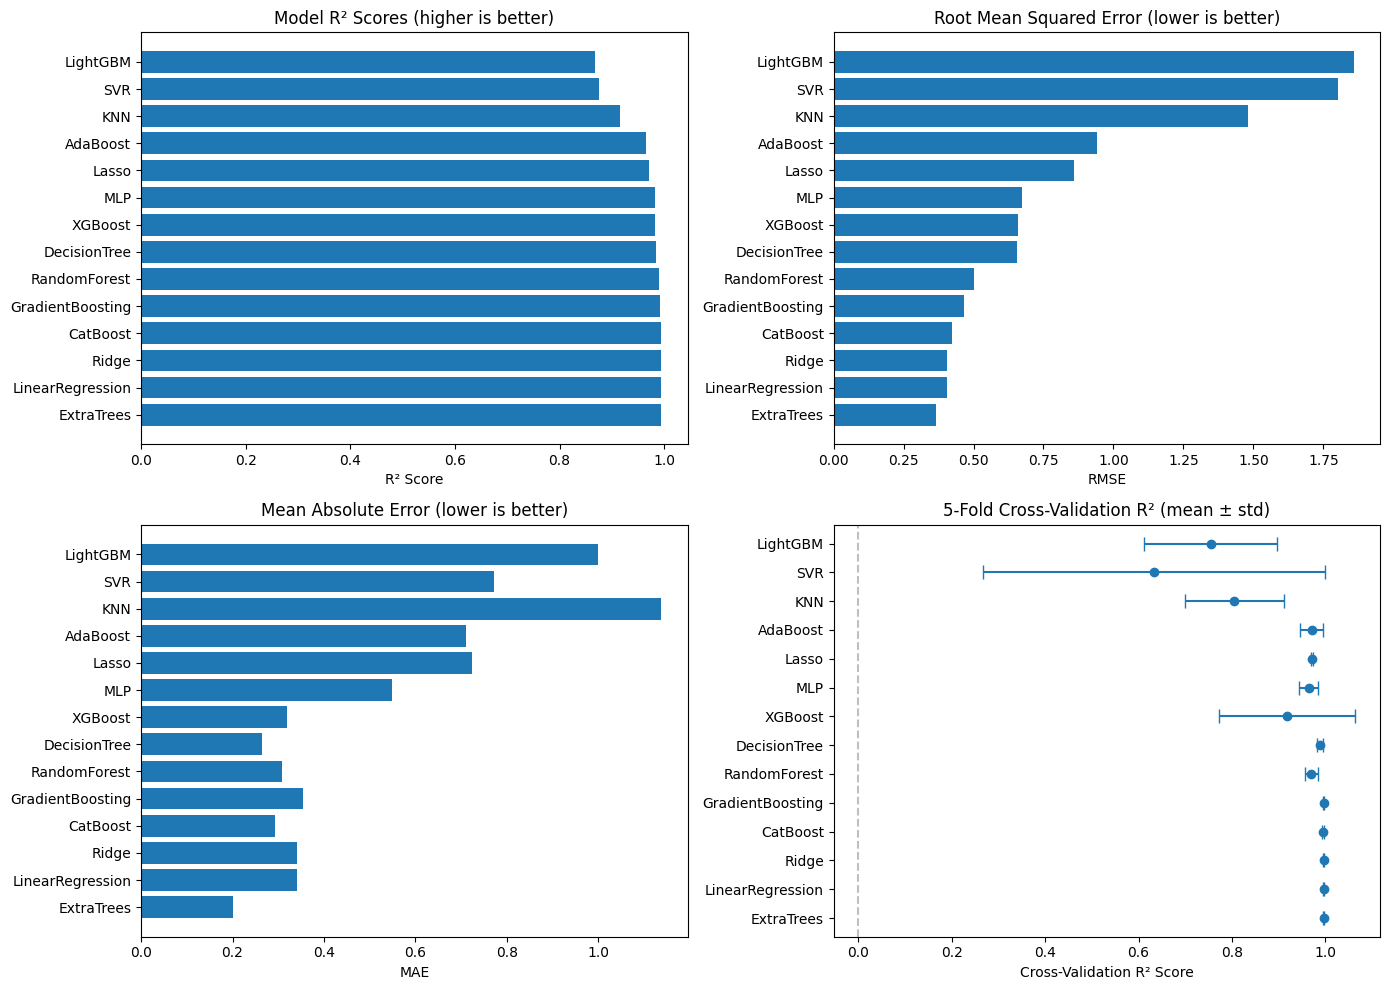


Best tree-based model: ExtraTrees (R²: 0.9949)

Top 10 Most Important Features:
     Feature  Importance
    city_mpg    0.466216
 highway_mpg    0.395479
   cylinders    0.072143
displacement    0.046737
   fuel_type    0.011391
       drive    0.004203
       class    0.002038
        make    0.000841
        year    0.000685
transmission    0.000266


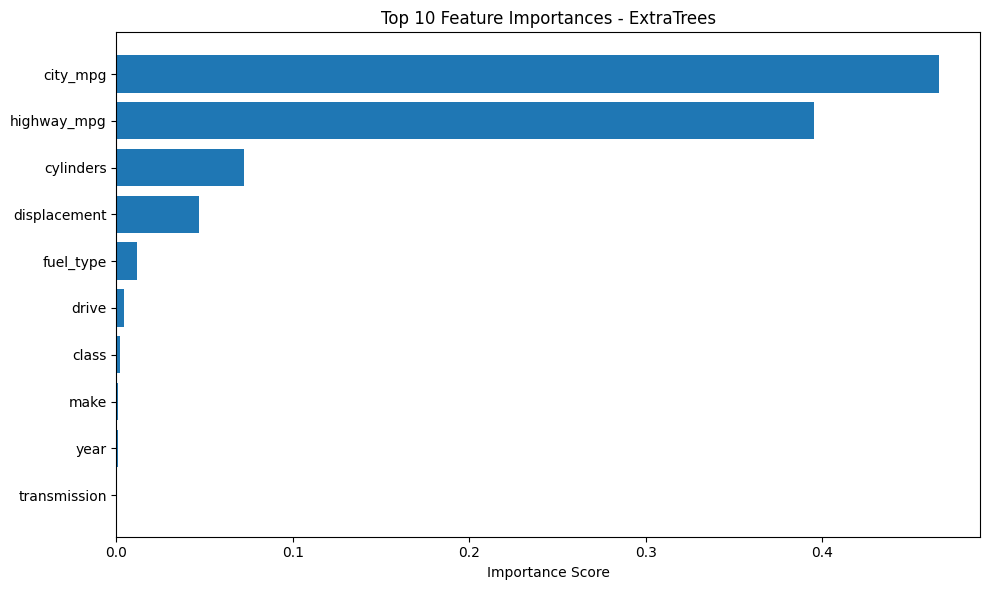


BEST OVERALL MODEL: ExtraTrees
R² Score: 0.9949
RMSE: 0.3643


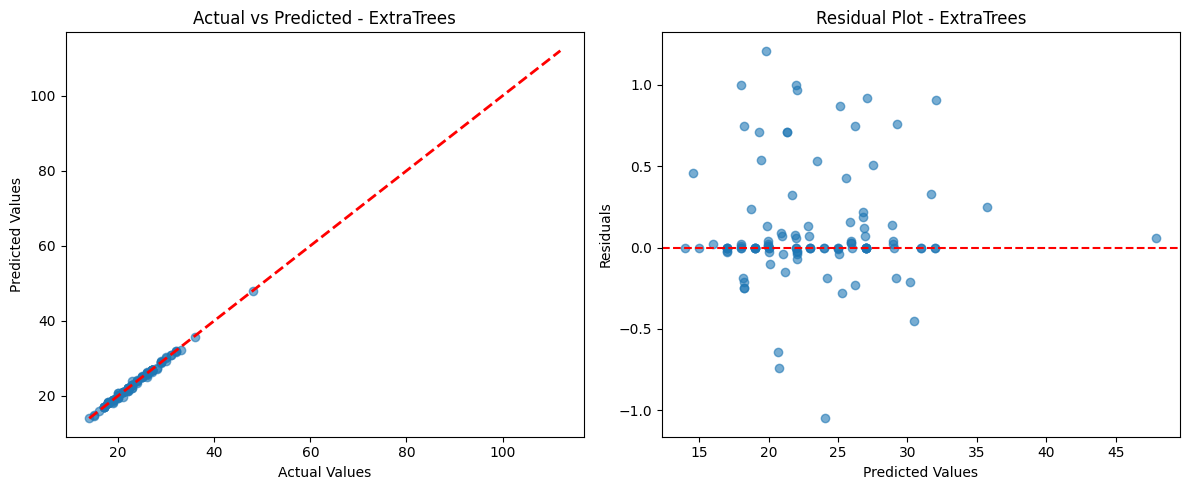


All models have been trained and evaluated successfully!


In [12]:
!pip install --upgrade pip
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Load and preprocess data
df = pd.read_csv('Car Data.csv')

# Handle missing values
for col in ['cylinders', 'displacement']:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# Encode categorical variables
categorical_cols = ['class', 'drive', 'fuel_type', 'make', 'transmission']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Prepare features and target
X = df.drop(['combination_mpg', 'model'], axis=1)
y = df['combination_mpg']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
MODEL_SPECS = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "ExtraTrees": ExtraTreesRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "MLP": MLPRegressor(random_state=42, max_iter=1000),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0),
    "LightGBM": LGBMRegressor(random_state=42, verbose=-1)
}

# Define which models need scaling
models_needing_scaling = ['MLP', 'KNN', 'SVR', 'LinearRegression', 'Ridge', 'Lasso']

# Evaluation function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, needs_scaling=False):
    if needs_scaling:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test

    try:
        model.fit(X_tr, y_train)
        y_pred = model.predict(X_te)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        cv_scores = cross_val_score(model, X_tr, y_train, cv=5, scoring='r2')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        return {
            'Model': model_name,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2,
            'CV_R2_Mean': cv_mean,
            'CV_R2_Std': cv_std,
            'Trained': True
        }
    except Exception as e:
        return {
            'Model': model_name,
            'MSE': None,
            'RMSE': None,
            'MAE': None,
            'R2': None,
            'CV_R2_Mean': None,
            'CV_R2_Std': None,
            'Trained': False,
            'Error': str(e)
        }

# Train and evaluate all models
print("Training and evaluating models...\n")
results = []

for model_name, model in MODEL_SPECS.items():
    needs_scaling = model_name in models_needing_scaling
    result = evaluate_model(model, X_train, X_test, y_train, y_test, model_name, needs_scaling)
    results.append(result)

# Convert to DataFrame and sort by R2
results_df = pd.DataFrame(results)
trained_results = results_df[results_df['Trained'] == True].copy()
trained_results = trained_results.sort_values('R2', ascending=False)

# Display results
print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY (sorted by R² Score)")
print("="*80 + "\n")

for idx, row in trained_results.iterrows():
    print(f"{row['Model']:20s}")
    print(f"  R² Score:       {row['R2']:.4f}")
    print(f"  RMSE:           {row['RMSE']:.4f}")
    print(f"  MAE:            {row['MAE']:.4f}")
    print(f"  CV R² (5-fold): {row['CV_R2_Mean']:.4f} ± {row['CV_R2_Std']:.4f}")
    print("-"*60)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].barh(trained_results['Model'], trained_results['R2'])
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Model R² Scores (higher is better)')
axes[0, 0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)

axes[0, 1].barh(trained_results['Model'], trained_results['RMSE'])
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_title('Root Mean Squared Error (lower is better)')

axes[1, 0].barh(trained_results['Model'], trained_results['MAE'])
axes[1, 0].set_xlabel('MAE')
axes[1, 0].set_title('Mean Absolute Error (lower is better)')

y_pos = np.arange(len(trained_results['Model']))
axes[1, 1].errorbar(trained_results['CV_R2_Mean'], y_pos,
                    xerr=trained_results['CV_R2_Std'],
                    fmt='o', capsize=5)
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels(trained_results['Model'])
axes[1, 1].set_xlabel('Cross-Validation R² Score')
axes[1, 1].set_title('5-Fold Cross-Validation R² (mean ± std)')
axes[1, 1].axvline(x=0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Feature importance for best tree-based model
tree_models = ['RandomForest', 'GradientBoosting', 'ExtraTrees',
               'DecisionTree', 'XGBoost', 'CatBoost', 'LightGBM']
best_tree_model_name = None
best_tree_score = -np.inf

for model_name in tree_models:
    model_row = trained_results[trained_results['Model'] == model_name]
    if not model_row.empty:
        score = model_row.iloc[0]['R2']
        if score > best_tree_score:
            best_tree_score = score
            best_tree_model_name = model_name

if best_tree_model_name:
    print(f"\nBest tree-based model: {best_tree_model_name} (R²: {best_tree_score:.4f})")
    best_model = MODEL_SPECS[best_tree_model_name]

    if best_tree_model_name in models_needing_scaling:
        best_model.fit(X_train_scaled, y_train)
    else:
        best_model.fit(X_train, y_train)

    # Get feature importance
    if hasattr(best_model, 'feature_importances_'):
        feature_importance = best_model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(importance_df.head(10).to_string(index=False))

        plt.figure(figsize=(10, 6))
        top_features = importance_df.head(10)
        plt.barh(range(len(top_features)), top_features['Importance'])
        plt.yticks(range(len(top_features)), top_features['Feature'])
        plt.xlabel('Importance Score')
        plt.title(f'Top 10 Feature Importances - {best_tree_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

# Best model analysis
if not trained_results.empty:
    best_overall = trained_results.iloc[0]
    best_model_name = best_overall['Model']
    best_model = MODEL_SPECS[best_model_name]

    print(f"\n" + "="*80)
    print(f"BEST OVERALL MODEL: {best_model_name}")
    print(f"R² Score: {best_overall['R2']:.4f}")
    print(f"RMSE: {best_overall['RMSE']:.4f}")
    print("="*80)

    if best_model_name in models_needing_scaling:
        best_model.fit(X_train_scaled, y_train)
        y_pred = best_model.predict(X_test_scaled)
    else:
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)

    # Plot predictions vs actual
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted - {best_model_name}')

    residuals = y_test - y_pred
    plt.subplot(1, 2, 2)
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot - {best_model_name}')

    plt.tight_layout()
    plt.show()

print("\nAll models have been trained and evaluated successfully!")